In [186]:
import itertools
import os
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px

pd.set_option('display.max_rows', 4)

In [187]:
d_experiment_logs = Path('../DA_logs/')

In [188]:
test_logs = []
for dir_experiment in d_experiment_logs.iterdir():
    for log_file in dir_experiment.iterdir():
        if log_file.name.startswith('test'):
            test_logs.append(log_file)

In [189]:
def add_metric_val(metrics: dict, dataset: str, method: str, metric_name: str, metric_val: float) -> None:
    method = method.split('-')[0]
    if dataset not in metrics:
        metrics[dataset] = {}
    if method not in metrics[dataset]:
        metrics[dataset][method] = {}
    if metric_name not in metrics[dataset][method]:
        metrics[dataset][method][metric_name] = []
    metrics[dataset][method][metric_name].append(metric_val)


total_dfs = dict()

for test_log in test_logs:
    train_params = None
    metrics = {}
    with open(test_log) as test_in:
        for line in test_in:
            if line.startswith('Namespace('):
                line = line.replace('Namespace', 'dict')
                train_params = eval(line)
            else:
                if line.startswith(' * Acc@1'):
                    acc = float(line.split()[-1])
                    add_metric_val(metrics, train_params['data_name'] + '.' + test_log.parent.name.split('_')[-2], train_params['log'], 'accuracy', acc)
                elif line.startswith(' * Acc1'):
                    acc = float(line.split()[2])
                    add_metric_val(metrics, train_params['data_name'] + '.' + test_log.parent.name.split('_')[-2], train_params['log'], 'accuracy', acc)
                elif line.startswith('PR AUC') or line.startswith('F1 PR AUC'):
                    pr_auc = float(line.split()[-1])
                    add_metric_val(metrics, train_params['data_name'] + '.' + test_log.parent.name.split('_')[-2], train_params['log'], 'pr_auc', pr_auc)
                elif line.startswith('ROC AUC') or line.startswith('F1 ROC AUC'):
                    roc_auc = float(line.split()[-1])
                    add_metric_val(metrics, train_params['data_name'] + '.' + test_log.parent.name.split('_')[-2], train_params['log'], 'roc_auc', roc_auc)
    
        for ds_name, ds in metrics.items():
            cur_metrics = None
            result = []
            for method_name, method_data in ds.items():
                if cur_metrics is None:
                    cur_metrics = list(method_data.keys())
                row = dict(zip(['method', *cur_metrics],
                               [method_name] +
                               [f'{np.mean(method_data[metric]):.3f}' for metric in cur_metrics]))
                if method_name == 'src_only':
                    result.insert(0, row)
                else:
                    result.append(row)
            df = pd.DataFrame(result).set_index('method').astype(float)

            if ds_name not in total_dfs.keys():
                total_dfs[ds_name] = df.sort_index()
            else:
                total_dfs[ds_name] = pd.concat([total_dfs[ds_name], df]).sort_index()

import functools
resulting_df = functools.reduce(lambda x, y: pd.concat([x, y], axis=1), total_dfs.values())
resulting_df.columns = pd.MultiIndex.from_product([[k for k in total_dfs.keys()], list(total_dfs.values())[0].columns], names=['data', 'metric_type'])
display(resulting_df)

data        His.H3K27AC.Pancreas.Pancreatic_ductal_adenocarcinoma.mm10.hg38.cnn  \
metric_type                                                            accuracy   
method                                                                            
adda                                                    74.096                    
afn                                                     77.865                    
...                                                                         ...   
mdd                                                     74.721                    
src_only                                                79.017                    

data                         \
metric_type  pr_auc roc_auc   
method                        
adda         85.569  83.740   
afn          88.242  87.241   
...             ...     ...   
mdd          81.286  83.554   
src_only     89.284  88.242   

data        His.H3K27AC.Pancreas.Pancreatic_ductal_adenocarcinoma.hg38.mm10.cnn  \
metric_type                                                            accuracy   
method                                                                            
adda                                                    74.603                    
afn                                                     79.550                    
...                                                                         ...   
mdd                                                     80.067                    
src_only                                                80.912                    

data                        TFs.TBX21.Blood.Th1_Cells.mm10.hg38.rnn          \
metric_type  pr_auc roc_auc                                accuracy  pr_auc   
method                                                                        
adda         86.111  84.700                                  60.368  66.007   
afn          89.396  88.779                                  62.334  67.536   
...             ...     ...                                     ...     ...   
mdd          89.392  89.155                                  64.067  70.440   
src_only     89.985  89.479                                  67.210  74.482   

data                TFs.TBX21.Blood.Th1_Cells.hg38.mm10.rnn  ...  \
metric_type roc_auc                                accuracy  ...   
method                                                       ...   
adda         65.133                                  60.290  ...   
afn          66.566                                  61.824  ...   
...             ...                                     ...  ...   
mdd          69.008                                  62.495  ...   
src_only     74.078                                  71.244  ...   

data        TFs.TBX21.Blood.Th1_Cells.hg38.mm10.cnn  \
metric_type                                 roc_auc   
method                                                
adda                                         84.247   
afn                                          89.193   
...                                             ...   
mdd                                          89.611   
src_only                                     89.593   

data        TFs.TBX21.Blood.Th1_Cells.mm10.hg38.cnn                  \
metric_type                                accuracy  pr_auc roc_auc   
method                                                                
adda                                         70.062  81.496  79.496   
afn                                          73.966  84.034  82.865   
...                                             ...     ...     ...   
mdd                                          70.537  76.474  78.058   
src_only                                     74.793  84.798  83.750   

data        His.H3K27AC.Pancreas.Pancreatic_ductal_adenocarcinoma.mm10.hg38.rnn  \
metric_type                                                            accuracy   
method                                                             

In [190]:
df = resulting_df.melt(ignore_index=False).reset_index()
df = pd.concat([df, df['data'].str.split('.', expand=True)], axis=1)
df = df.drop('data', axis=1)
df.columns = ['method', 'metric', 'score', 'antigen_type', 'antigen', 'cell_class', 'cell_type', 'organism_from', 'organism_to', 'network']
df['transition'] = df['organism_from'] + '.' + df['organism_to']
df = df.drop(['organism_from', 'organism_to'], axis=1)
df['network'] = df['network'].str.replace("cnn","CNN", regex=False).str.replace("rnn","LSTM",regex=False)
df = df.sort_values(['transition', 'method', 'network'])
df['score'] /= 100
df['full_title'] = df.apply(lambda x: f"<b>{x['antigen']}</b>: {x['cell_class']} - {x['cell_type']}", axis=1)
df

,method,metric,score,antigen_type,antigen,cell_class,cell_type,network,transition,full_title
30,adda,accuracy,0.74603,His,H3K27AC,Pancreas,Pancreatic_ductal_adenocarcinoma,CNN,hg38.mm10,<b>H3K27AC</b>: Pancreas - Pancreatic_ductal_a...
40,adda,pr_auc,0.86111,His,H3K27AC,Pancreas,Pancreatic_ductal_adenocarcinoma,CNN,hg38.mm10,<b>H3K27AC</b>: Pancreas - Pancreatic_ductal_a...
...,...,...,...,...,...,...,...,...,...,...
199,src_only,pr_auc,0.78870,His,H3K27AC,Pancreas,Pancreatic_ductal_adenocarcinoma,LSTM,mm10.hg38,<b>H3K27AC</b>: Pancreas - Pancreatic_ductal_a...
209,src_only,roc_auc,0.77992,His,H3K27AC,Pancreas,Pancreatic_ductal_adenocarcinoma,LSTM,mm10.hg38,<b>H3K27AC</b>: Pancreas - Pancreatic_ductal_a...


In [191]:
h3k27ac_hybrid = pd.read_table('h3k27ac_pancreas.tsv')
h3k27ac_hybrid = h3k27ac_hybrid.rename(columns={'histone_mark': 'antigen', 'value':'score'})
h3k27ac_hybrid['network'] = 'CNN+LSTM'
h3k27ac_hybrid['antigen_type'] = 'His'
h3k27ac_hybrid['antigen'] = h3k27ac_hybrid['antigen'].str.upper()
h3k27ac_hybrid

,method,antigen,cell_class,cell_type,full_title,transition,metric,score,network,antigen_type
0,adda,H3K27AC,Pancreas,Pancreatic_ductal_adenocarcinoma,<b>H3K27ac</b>: Pancreas - Pancreatic_ductal_a...,mm10.hg38,accuracy,0.72246,CNN+LSTM,His
1,afn,H3K27AC,Pancreas,Pancreatic_ductal_adenocarcinoma,<b>H3K27ac</b>: Pancreas - Pancreatic_ductal_a...,mm10.hg38,accuracy,0.72945,CNN+LSTM,His
...,...,...,...,...,...,...,...,...,...,...
58,mdd,H3K27AC,Pancreas,Pancreatic_ductal_adenocarcinoma,<b>H3K27ac</b>: Pancreas - Pancreatic_ductal_a...,hg38.mm10,roc_auc,0.85988,CNN+LSTM,His
59,src_only,H3K27AC,Pancreas,Pancreatic_ductal_adenocarcinoma,<b>H3K27ac</b>: Pancreas - Pancreatic_ductal_a...,hg38.mm10,roc_auc,0.87554,CNN+LSTM,His


In [192]:
tbx21_hybrid = pd.read_table('tbx21_blood.tsv')
tbx21_hybrid = tbx21_hybrid.rename(columns={'tf': 'antigen', 'value':'score'})
tbx21_hybrid['network'] = 'CNN+LSTM'
tbx21_hybrid['antigen_type'] = 'TFs'
tbx21_hybrid

,method,antigen,cell_class,cell_type,full_title,transition,metric,score,network,antigen_type
0,adda,TBX21,Blood,Th1_Cells,<b>TBX21</b>: Blood - Th1_Cells,mm10.hg38,accuracy,0.70161,CNN+LSTM,TFs
1,afn,TBX21,Blood,Th1_Cells,<b>TBX21</b>: Blood - Th1_Cells,mm10.hg38,accuracy,0.70656,CNN+LSTM,TFs
...,...,...,...,...,...,...,...,...,...,...
58,mdd,TBX21,Blood,Th1_Cells,<b>TBX21</b>: Blood - Th1_Cells,hg38.mm10,roc_auc,0.87637,CNN+LSTM,TFs
59,src_only,TBX21,Blood,Th1_Cells,<b>TBX21</b>: Blood - Th1_Cells,hg38.mm10,roc_auc,0.90395,CNN+LSTM,TFs


In [193]:
df = pd.concat([df, h3k27ac_hybrid, tbx21_hybrid])
df['method'] = df['method'].str.upper().str.replace('SRC_ONLY', 'Source only', regex=False)
df['transition'] = df["transition"].str.replace('.', ' ➙ ', regex=False)
df

,method,metric,score,antigen_type,antigen,cell_class,cell_type,network,transition,full_title
30,ADDA,accuracy,0.74603,His,H3K27AC,Pancreas,Pancreatic_ductal_adenocarcinoma,CNN,hg38 ➙ mm10,<b>H3K27AC</b>: Pancreas - Pancreatic_ductal_a...
40,ADDA,pr_auc,0.86111,His,H3K27AC,Pancreas,Pancreatic_ductal_adenocarcinoma,CNN,hg38 ➙ mm10,<b>H3K27AC</b>: Pancreas - Pancreatic_ductal_a...
...,...,...,...,...,...,...,...,...,...,...
58,MDD,roc_auc,0.87637,TFs,TBX21,Blood,Th1_Cells,CNN+LSTM,hg38 ➙ mm10,<b>TBX21</b>: Blood - Th1_Cells
59,Source only,roc_auc,0.90395,TFs,TBX21,Blood,Th1_Cells,CNN+LSTM,hg38 ➙ mm10,<b>TBX21</b>: Blood - Th1_Cells


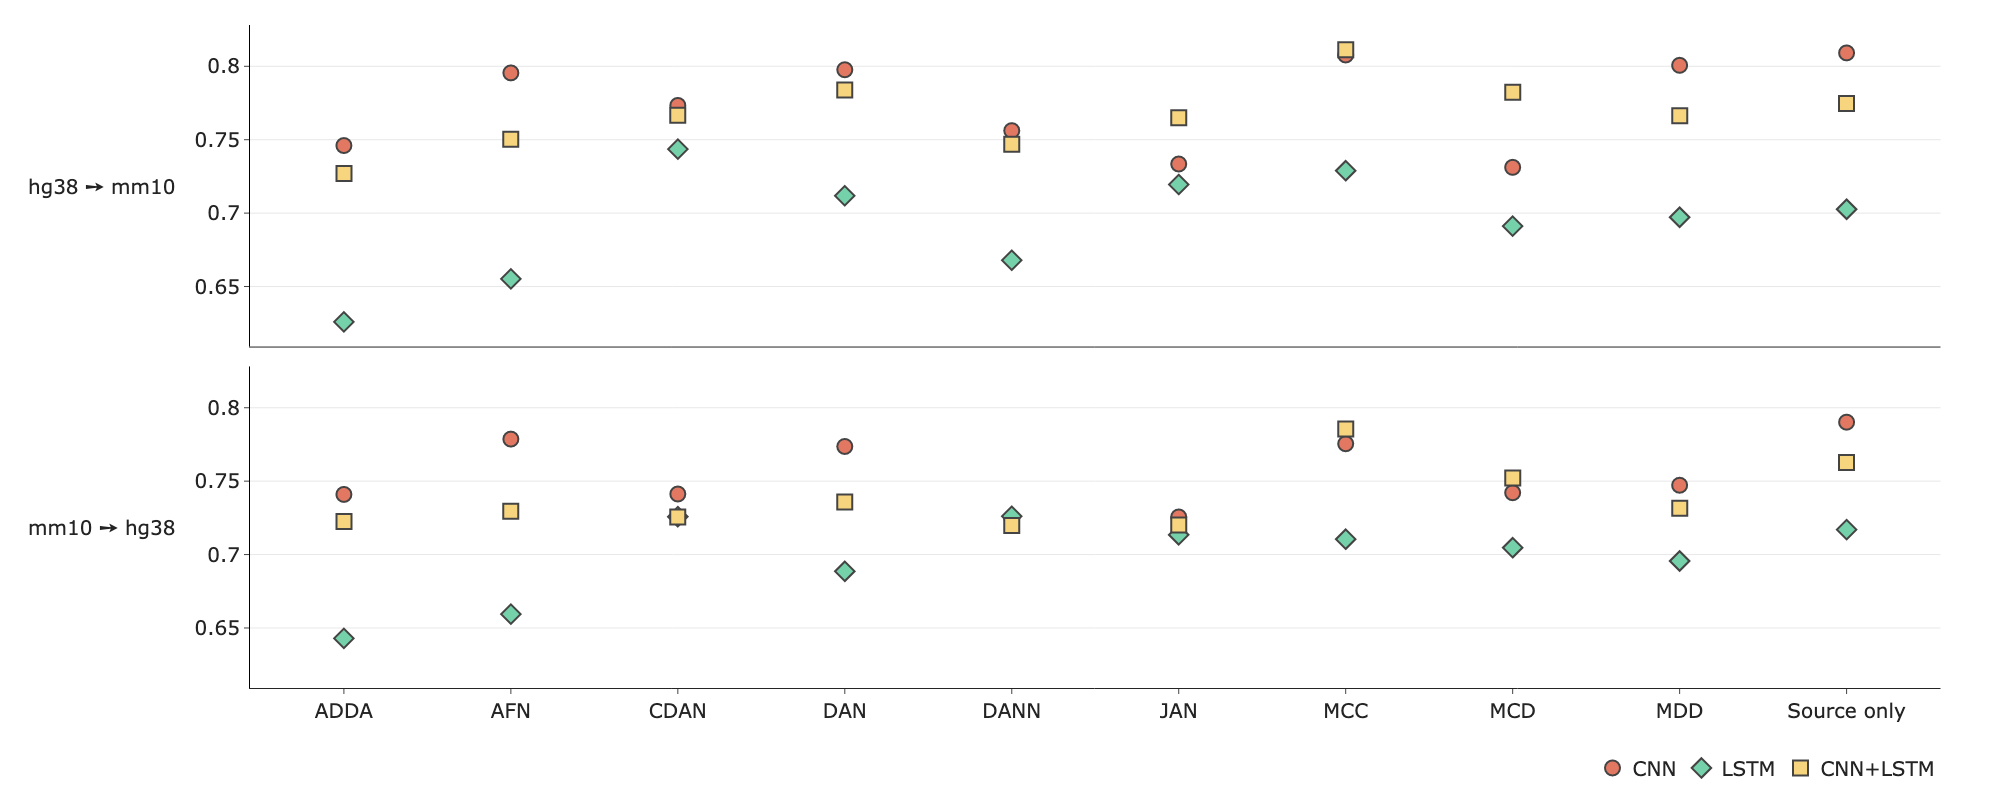

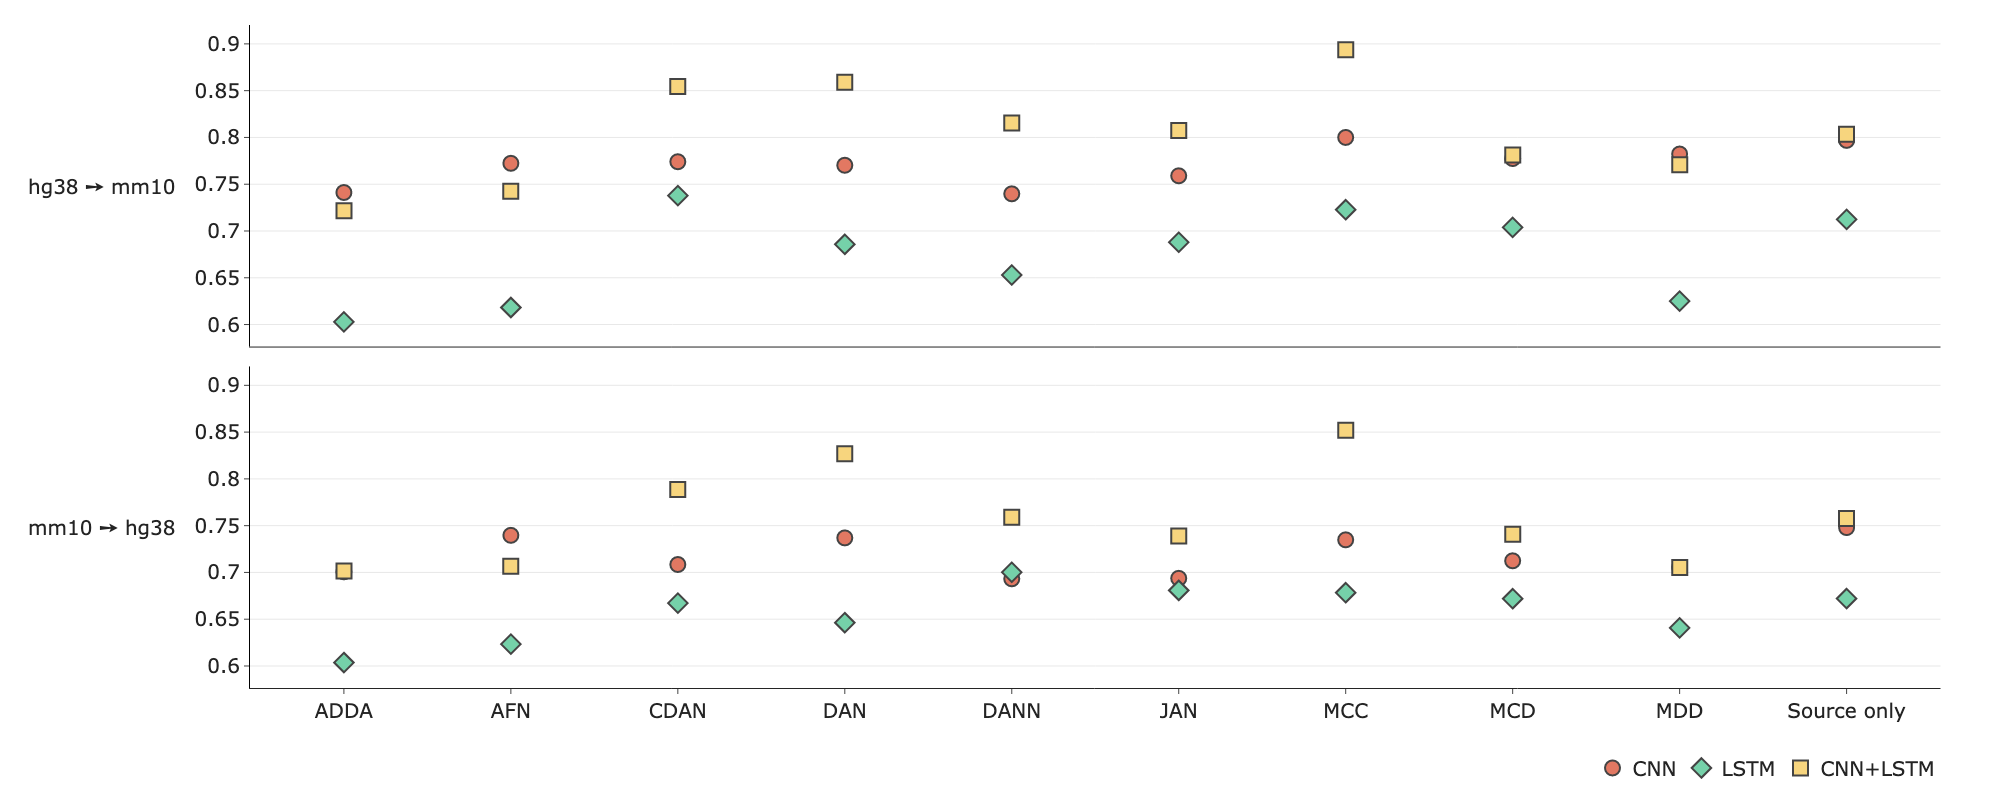

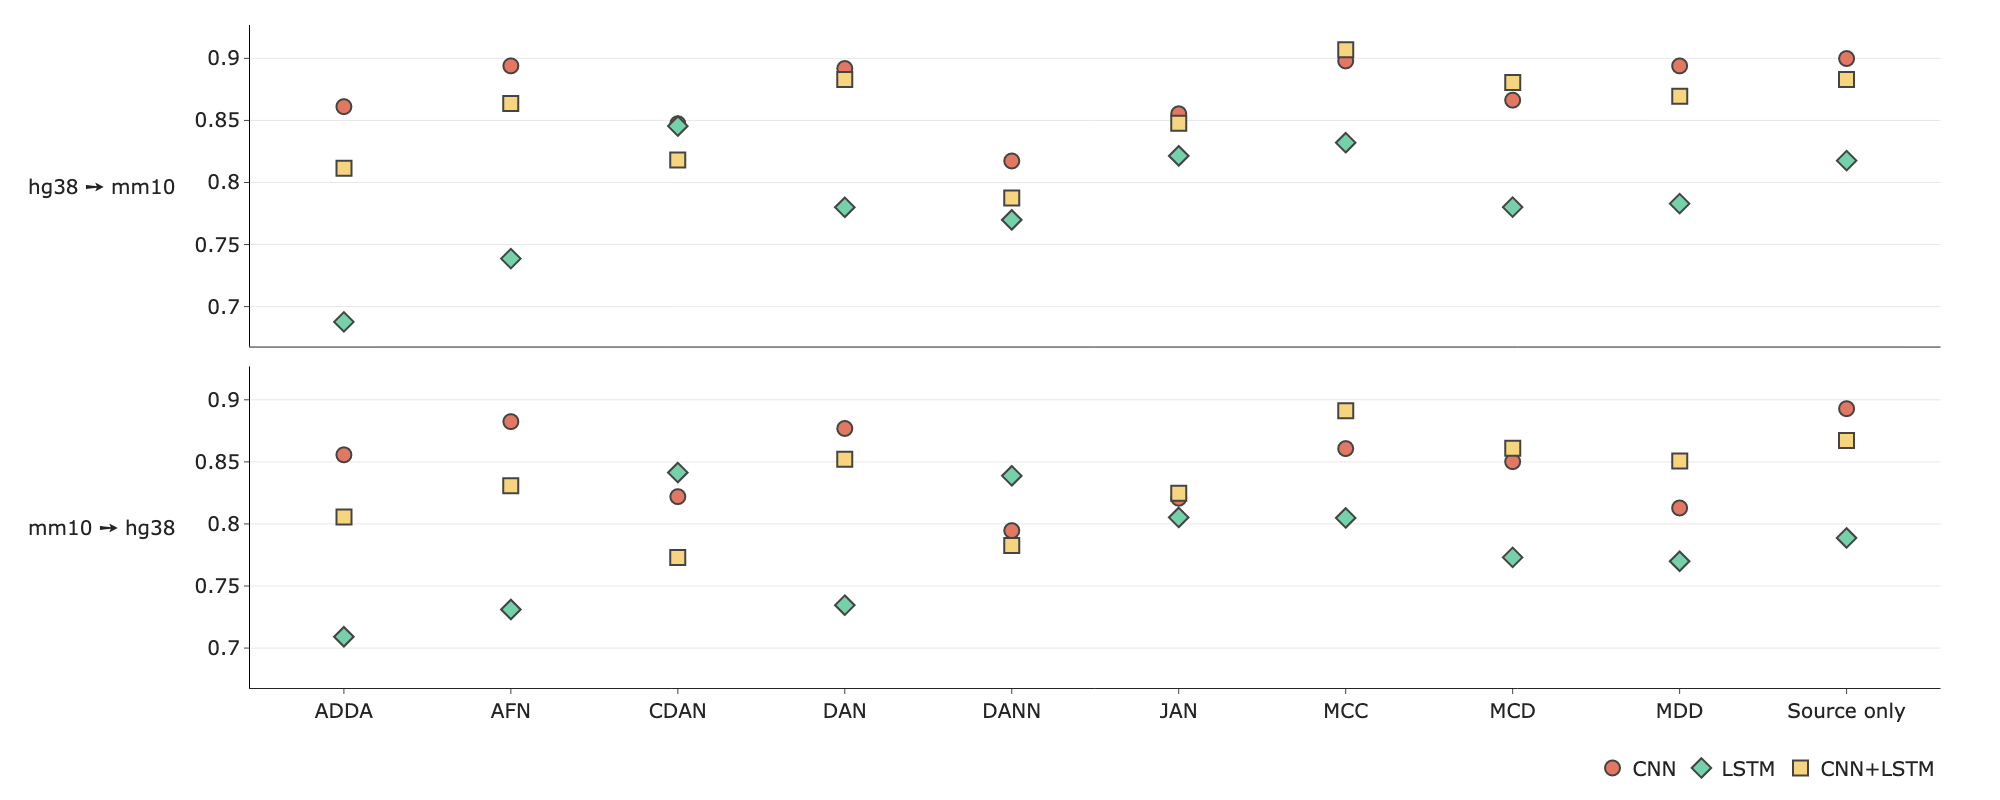

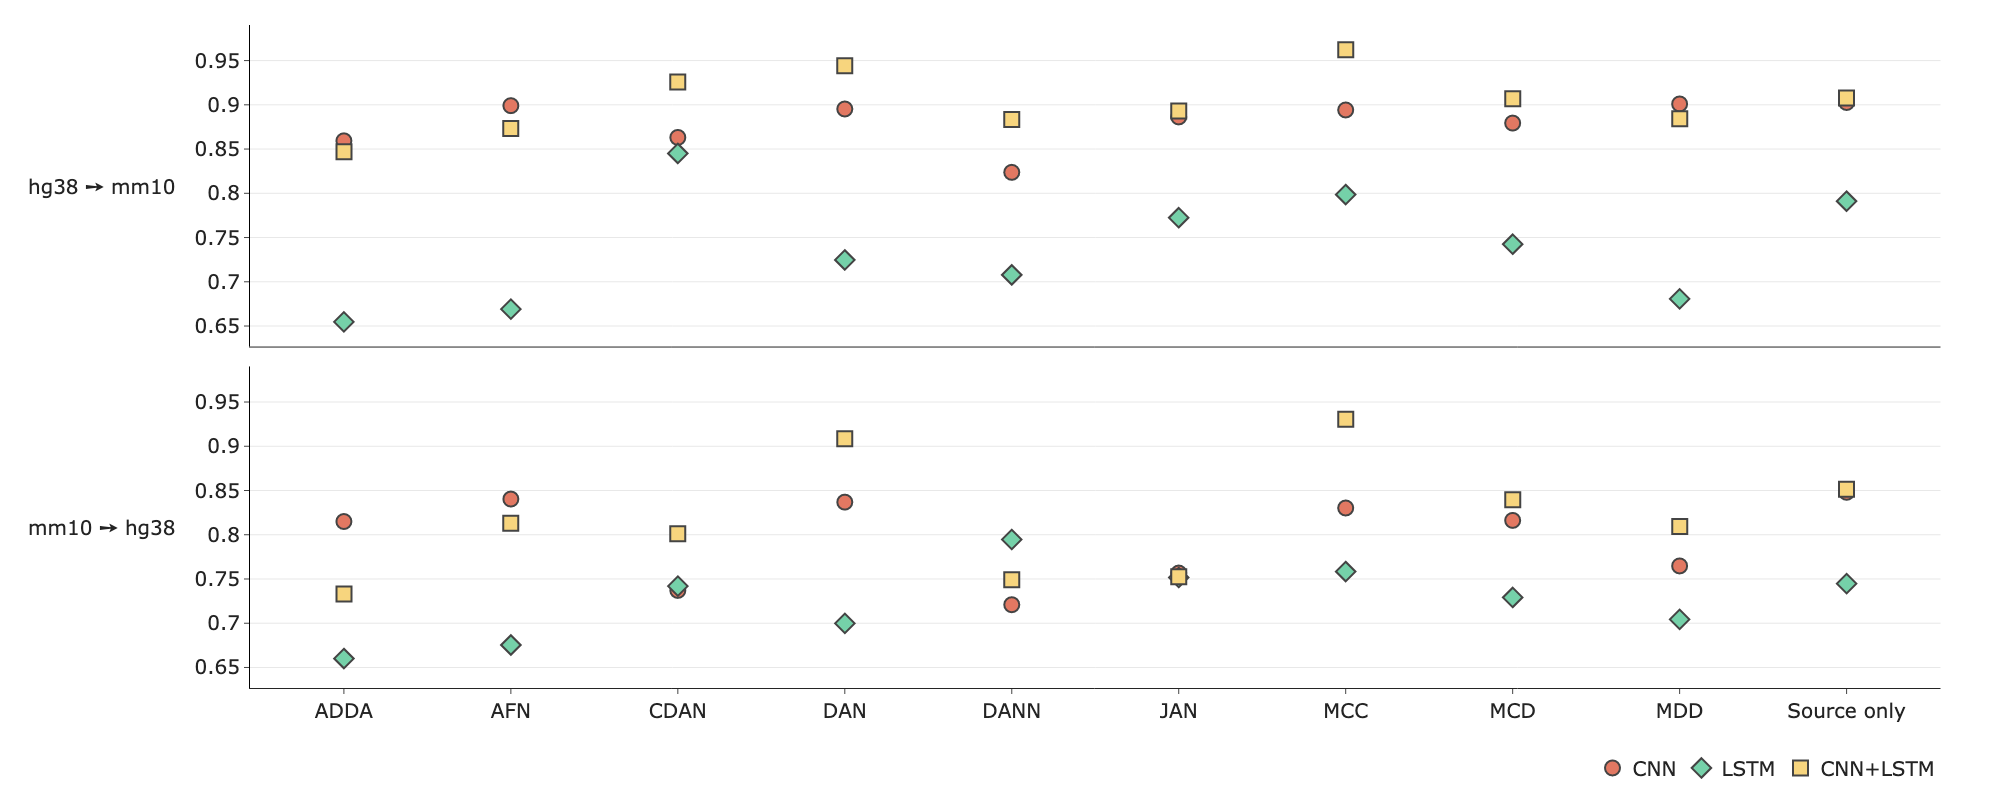

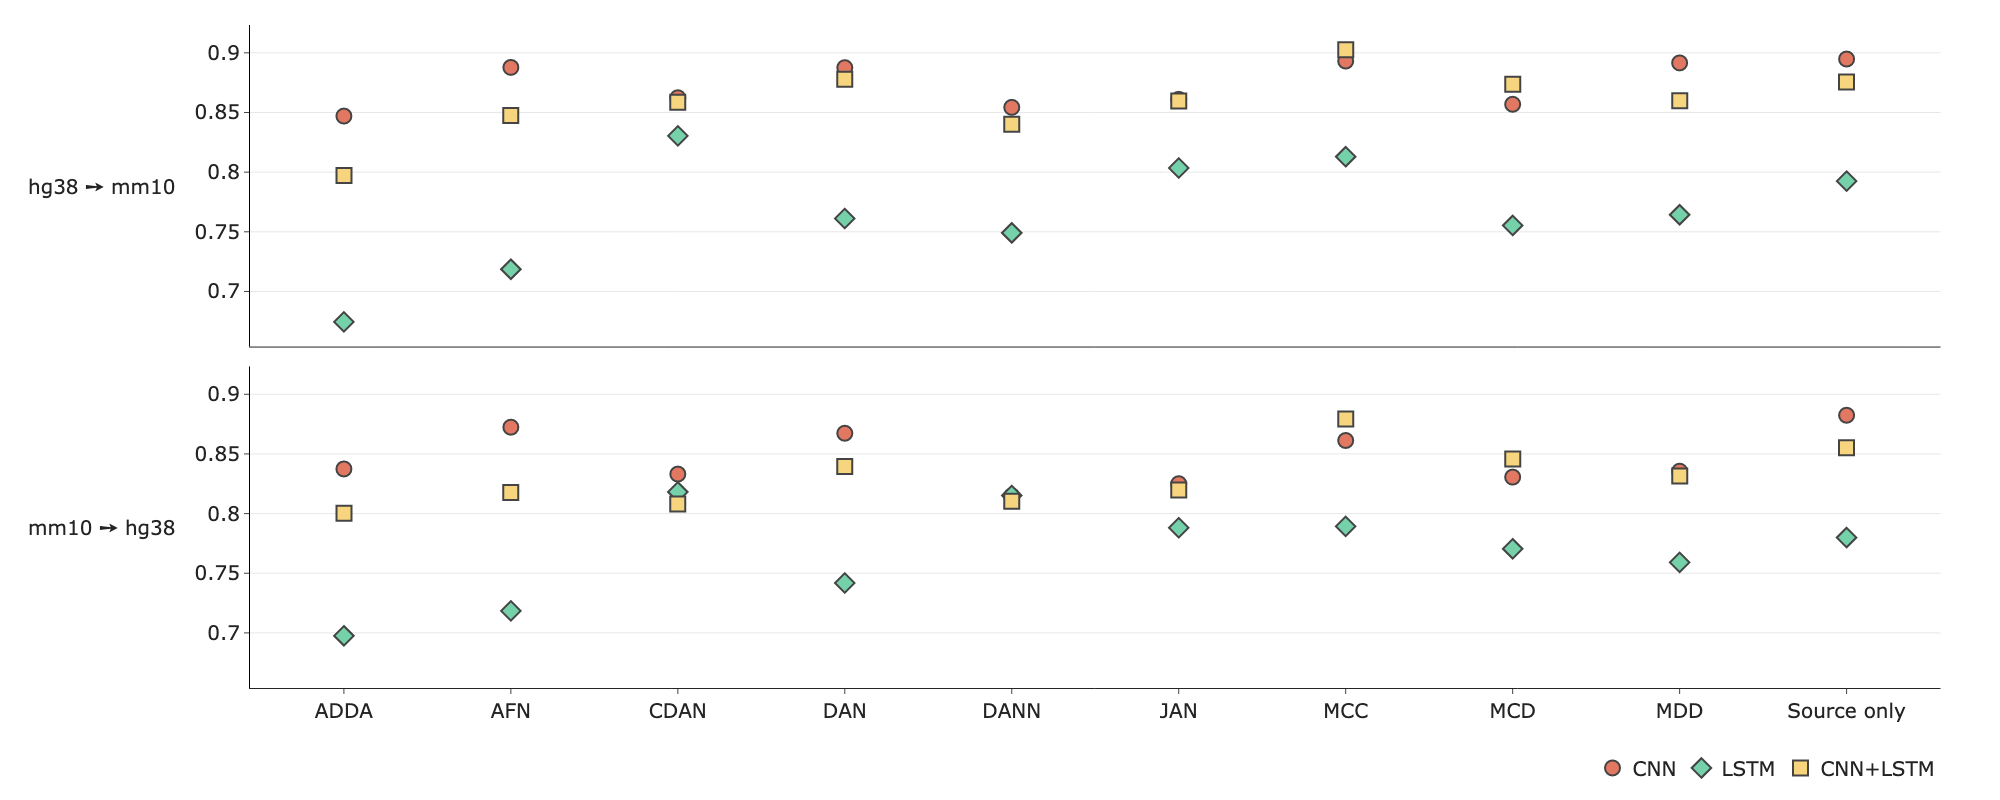

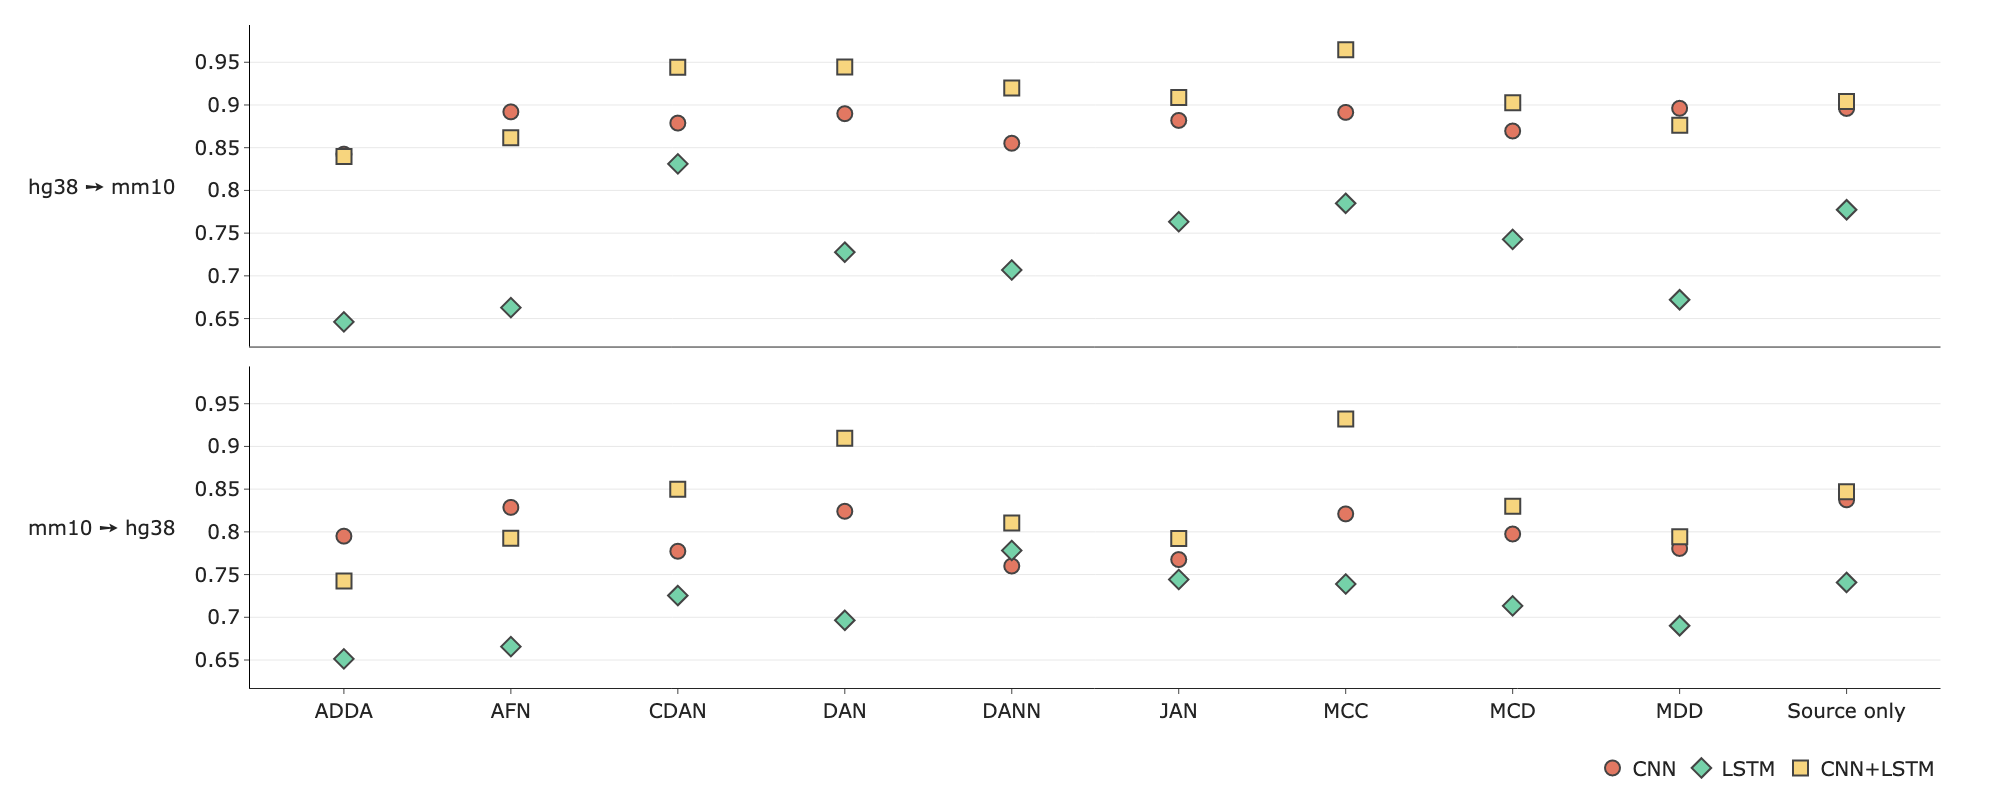

In [194]:
colors = {
    'CNN': "#E27862",
    'LSTM': "#75D1A9",
    'CNN+LSTM': "#F7D57E",
}

for metric in ["accuracy", "pr_auc", "roc_auc"]:
    for antigen in df['antigen'].unique():
        plotly_df = df[(df["metric"] == metric) & (df["antigen"] == antigen)].copy()
        unique_methods = sorted(df['method'].unique())
        unique_transitions = sorted(df['transition'].unique())

        fig = px.scatter(
            plotly_df,
            x="method",
            y="score",
            color="network",
            color_discrete_map=colors,
            symbol="network",
            facet_row="transition",
        )


        fig.update_yaxes(
            # ticks="",
            title="",
            showline=True,
            linewidth=1,
            linecolor="black",
            # mirror=True,
            # tickformat=".2",
            showgrid=True,
        )

        fig.update_xaxes(title="")
        fig.update_xaxes(
            ticks="",
            row=2
        )

        fig.update_annotations(textangle=0, font=dict(size=20), align="center")
        fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
        fig.for_each_annotation(lambda a: a.update(x = -.13) if a.text in unique_transitions else())

        fig.update_traces(marker=dict(size=15, line=dict(width=2)))

        height=400 * len(unique_transitions)
        width=200 * len(unique_methods)
        fig.update_layout(
            height=height,
            width=width,
            font=dict(size=20),
            margin=dict(l=250, t=25, b=50, r=25),
            legend=dict(
                title="",
                # font_size=20,
                # traceorder="reversed",
                orientation="h",
                yanchor="bottom",
                y=-0.15,
                xanchor="right",
                x=0.98,
            ),
            template="simple_white",
        )

        fig.write_image(f"img/compare_models_{antigen}_{metric}.png", scale=4)
        fig.show(renderer="png")
